## Iterative Algorithm for Neo-K-Means


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.io import loadmat
from sklearn.metrics import f1_score # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics.cluster import normalized_mutual_info_score # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html
from sklearn.decomposition import PCA
from numpy.random import choice
from numpy.random import seed

## K-Means++

In [114]:
def plot(data, centroids):
    plt.scatter(data[:, 0], data[:, 1], marker = '.',  
                color = 'gray', label = 'data points') 
    plt.scatter(centroids[:-1, 0], centroids[:-1, 1],  
                color = 'black', label = 'previously selected centroids') 
    plt.scatter(centroids[-1, 0], centroids[-1, 1],  
                color = 'red', label = 'next centroid') 
    plt.title('Select % d th centroid'%(centroids.shape[0])) 
    
    minlim = min(np.min(data[:, 0]), np.min(data[:, 1])) *1.1
    maxlim = max(np.max(data[:, 0]), np.max(data[:, 1])) *1.1
    
    plt.xlim(minlim, maxlim)
    plt.ylim(minlim, maxlim)
    plt.legend() 
    plt.show() 

def initialize_kmeanspp(data, k, norm_p):
    ''' 
    initialize the centroids according to K-means++ 
    inputs: 
        data - numpy array of data points (input, features)
        k - number of clusters
        norm_p - order for L norm
    '''
    ## initialize the centroids list and add 
    ## a randomly selected data point to the list 
    centroids = [] 
    centroids.append(data[np.random.randint(data.shape[0]), :])
    #plot(data, np.array(centroids)) 

    ## compute remaining k - 1 centroids 
    for c_id in range(k - 1): 
        ## initialize a list to store distances of data 
        ## points from nearest centroid 
        dist = [] 
        for point in data:
            dist.append(min(np.linalg.norm(point-centroids, ord=norm_p, axis=1)))

        ## select data point with maximum distance as our next centroid 
        dist = np.array(dist)**2
        next_centroid = data[np.random.choice(len(dist), p=dist/np.sum(dist))]
        #next_centroid = data[np.argmax(dist), :] 
        centroids.append(next_centroid)
    #plot(data, np.array(centroids))
    return np.array(centroids) 

### Datasets

* emotions (music)
* yeast
* scene

In [218]:
dataset = 'emotions'
with open("datasets/" + dataset + "/" + dataset + ".xml", 'r') as f:
    labels = [l.split("\"")[1] for l in f.readlines() if l.startswith("<label name=")]

with open("datasets/" + dataset + "/" + dataset + ".arff", 'r') as f:
    data = f.readlines()
    data = data[data.index('@data\n')+1:]
    data = np.array([np.array(list(map(float, d.split(',')))) for d in data])
    data_x = data[:, :-len(labels)]
    data_y = data[:, -len(labels):].astype(int)

* yahoo image
  * vision 1: "Wood", "Glass"
  * vision 2: "Nose", "Hair", "Arm", "Foot/Shoe", "Metal", "Furry"
  * vision 3: "Mouth", "Face", "Nose", "Hair", "Wood", "Glass", "Horn"

In [3]:
data_x_all = np.array(loadmat('datasets/image_dataset/attribute_features/feat_ayahoo_test.mat')['feat'].T.todense())
with open("datasets/image_dataset/attribute_data/ayahoo_test.txt", 'r') as f:
    ff = f.readlines()
    data_y_all = np.array([l.split()[6:] for l in ff]).astype(int)
    data_info_all = np.array([l.split()[:6] for l in ff])
with open("datasets/image_dataset/attribute_data/attribute_names.txt", 'r') as f:
    labels_all = [l.strip() for l in f.readlines()]

In [4]:
labels = ["Wood", "Glass"] # vision 1
#labels = ["Nose", "Hair", "Arm", "Foot/Shoe", "Metal", "Furry"] # vision 2
#labels = ["Mouth", "Face", "Nose", "Hair", "Wood", "Glass", "Horn"] # vision 3

data_x = []
data_y = []
data_info = []
lidx_list = []
for label in labels:
    lidx = labels_all.index(label)
    lidx_list.append(lidx)
    data_x.extend(data_x_all[data_y_all[:, lidx]==1])
    data_y.extend(data_y_all[data_y_all[:, lidx]==1])
    data_info.extend(data_info_all[data_y_all[:, lidx]==1])
data_x = np.array(data_x)
data_y = np.array(data_y)
data_info = np.array(data_info)

_, idx = np.unique(data_x, axis=0, return_index=True)
data_x = data_x[np.sort(idx)]
data_y = data_y[np.sort(idx)][:,lidx_list]
data_info = data_info[np.sort(idx)]

### PCA (Optional)

([<matplotlib.lines.Line2D at 0x1a6f1756d30>], 72, 2)

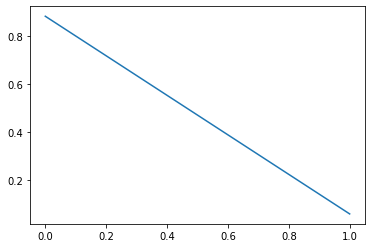

In [225]:
pca = PCA()
pca.fit(data_x)
n_components = np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.95)
plt.plot(pca.explained_variance_ratio_[:n_components]), data_x.shape[1], n_components

In [226]:
pca = PCA(n_components=n_components, whiten=False, svd_solver='full')
data_x = pca.fit_transform(data_x)

## Initializations

In [227]:
def compute_d_p(X, centroids, p):
    # If a 1-D array is provided, 
    # it will be reshaped to a single row 2-D array
    if len(centroids.shape) == 1: 
        centroids = centroids.reshape((1,len(centroids)))
    
    n = len(X)
    k = len(centroids)
    
    dists = np.zeros((n,k))
    for i in range(n):
        dists[i, :] = np.linalg.norm(X[i, :] - centroids, ord=p, axis=1) #**p

    return dists

In [228]:
n = data_x.shape[0] # no of data points
m = data_x.shape[1] # no of feauters
k = len(labels) # cluster size 
norm_p = 2
algorithm = 'means' # means, medians, medoids

In [229]:
kmeans = KMeans(n_clusters=k).fit(data_x)

kmeans_dists = np.zeros((n))
for i, pt in enumerate(data_x):
    kmeans_dists[i] = np.linalg.norm(pt-kmeans.cluster_centers_[kmeans.labels_[i]])**2
    
kmeans_dists_mean = kmeans_dists.mean()
kmeans_dists_std = kmeans_dists.std()
kmeans_dists_thr = kmeans_dists_mean + 3*kmeans_dists_std
kmeans_dists_outliers = [1 if d > kmeans_dists_thr else 0 for d in kmeans_dists]

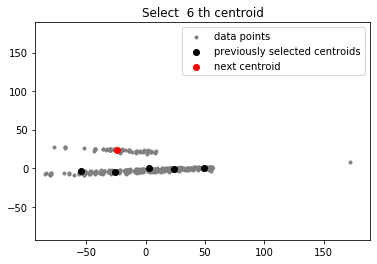

In [231]:
#seed(1)

# k-medoids
# samples = choice(len(data_x), size=k, replace=False)
# centroids = medoids = data_x[samples, :]
# centroids = medoids = initialize_kmeanspp(data_x, k, norm_p) 


# k-median
#centroids = np.array([np.median(data_x, axis = 0) + np.random.normal(scale=data_x.std(axis = 0), size=m) for _ in range(k)]) # Assign m + normal distribution around s for each dimension.
#centroids = np.array([np.median(data_x, axis = 0)+0.5*data_x.std(axis = 0)*(-1+l*2/(k-1)) for l in range(k)]) # Assign values from (m-s) to (m+s) with equal intervals for each dimension.

# k-mean
#centroids = np.array([data_x.mean(axis = 0) + np.random.normal(scale=data_x.std(axis = 0), size=m) for _ in range(k)]) # Assign m + normal distribution around s for each dimension.
#centroids = np.array([data_x.mean(axis = 0)+data_x.std(axis = 0)*(-1+l*2/(k-1)) for l in range(k)]) # Assign values from (m-s) to (m+s) with equal intervals for each dimension.
centroids = kmeans.cluster_centers_.copy()

alpha = np.sqrt(k)-1
beta = sum(kmeans_dists_outliers)/n
sum_diff = 1

if m == 2:
    plot(data_x, centroids)

## NEO-K-Ms

Diff (1): 794.928086
Diff (2): 69.092522
Diff (3): 16.641555
Diff (4): 1.925869
Diff (5): 1.190294
Diff (6): 0.273447
Diff (7): 0.032502
Diff (8): 0.024857
Diff (9): 0.000000


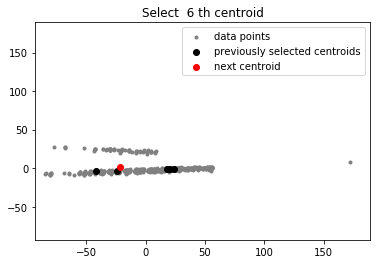

In [232]:
for t in range(25):
    old_centroids = centroids.copy()
            
    C_bar = [[] for _ in range(k)]
    C_hat = [[] for _ in range(k)]
    outliers = [i for i in range(n)]
    T = []
    S = []
    
    if algorithm == 'means':
        dists = compute_d_p(data_x, centroids, 2)**2
        #dists = np.array([[np.mean(np.linalg.norm(data_x[i] - data_x[C_all[j]], ord=2, axis=1)**2) for j in range(k)] for i in range(n)])
    elif algorithm == 'medians':
        dists = compute_d_p(data_x, centroids, 1)
    else:
        dists = compute_d_p(data_x, centroids, norm_p)
            
    dists_argsorted = dists.flatten().argsort()
    p = 0
    i = 0
    while p < n-beta*n:
        pt_ind = dists_argsorted[i]
        if pt_ind//k not in S:
            C_bar[pt_ind%k].append(pt_ind//k)
            S.append(pt_ind//k)
            T.append((pt_ind//k, pt_ind%k))
            outliers.remove(pt_ind//k)
            p += 1
        i += 1
    
        
    i = 0
    while p < n+alpha*n:
        pt_ind = dists_argsorted[i]
        if (pt_ind//k, pt_ind%k) not in T:
            C_hat[pt_ind%k].append(pt_ind//k)
            T.append((pt_ind//k, pt_ind%k))
            if pt_ind//k in outliers:
                outliers.remove(pt_ind//k)
            p += 1
        i += 1
        
    C_all = [C_bar[i]+C_hat[i] for i in range(len(C_hat))]
    
    # Update Centroids 
    if algorithm == 'means':
        for i in range(k):
            centroids[i] = data_x[C_all[i]].mean(axis=0)
        sum_diff = (np.linalg.norm(old_centroids-centroids, axis=1)**2).sum()

        print("Diff (%d): %f" % (t+1, sum_diff) )
        if sum_diff < 0.01 or np.isnan(sum_diff):
            break
    
    elif algorithm == 'medians':
        for i in range(k):
            centroids[i] = np.median(data_x[C_all[i]], axis=0) # k-medians
        sum_diff = (np.linalg.norm(old_centroids-centroids, axis=1, ord=1)).sum() # k-medians

        print("Diff (%d): %f" % (t+1, sum_diff) )
        if sum_diff < 0.01 or np.isnan(sum_diff):
            break
    
    else:
        print("Diff (%d): " % (t+1), end='')
        for i in range(k):
            cluster_points = data_x[C_all[i]]
            old_avg_dissimilarity = avg_dissimilarity = np.sum(compute_d_p(cluster_points, centroids[i], norm_p))

            for datap in cluster_points:
                new_dissimilarity= np.sum(compute_d_p(cluster_points, datap, norm_p))

                if new_dissimilarity < avg_dissimilarity :
                    avg_dissimilarity = new_dissimilarity
                    centroids[i] = datap
                    
            print("%f " % (old_avg_dissimilarity-avg_dissimilarity), end='')
        print()
        if (set([tuple(x) for x in old_centroids]) == set([tuple(x) for x in centroids])):
            break
            
if m == 2:
    plot(data_x, centroids)

In [234]:
pred_y = [[0]*k for _ in range(n)]
for i, C in enumerate(C_all):
    for l in C:
        pred_y[l][i] = 1
pred_y = np.array(pred_y)

In [235]:
# Average F1
# Overlapping Community Detection at Scale:A Nonnegative Matrix Factorization Approach

# pred to ground-truth
f1_score_ptog = 0
for i in range(k):
    f1_temp = np.array([f1_score(data_y[:,j], pred_y[:,i], average='binary') for j in range(k)])
    f1_score_ptog += f1_temp.max()
    #print(f1_temp.argmax(), f1_temp.max())

#print(f1_score_ptog/k)
#print()

# ground-truth to pre
f1_score_gtop = 0
for i in range(k):
    f1_temp = np.array([f1_score(data_y[:,i], pred_y[:,j], average='binary') for j in range(k)])
    f1_score_gtop += f1_temp.max()
    #print(f1_temp.argmax(), f1_temp.max())
    
#print(f1_score_gtop/k)
#print()

f1_average = (f1_score_ptog/k + f1_score_gtop/k)/2
print(f1_average*100)

41.70552279483146


In [236]:
# Average NMI

# pred to ground-truth
nmi_score_ptog = 0
for i in range(k):
    nmi_temp = np.array([normalized_mutual_info_score(data_y[:,j], pred_y[:,i], average_method='geometric') for j in range(k)])
    nmi_score_ptog += nmi_temp.max()
#     print(nmi_temp.argmax(), nmi_temp.max())

# print(nmi_score_ptog/k)
# print()

# ground-truth to pre
nmi_score_gtop = 0
for i in range(k):
    nmi_temp = np.array([normalized_mutual_info_score(data_y[:,i], pred_y[:,j], average_method='geometric') for j in range(k)])
    nmi_score_gtop += nmi_temp.max()
#     print(nmi_temp.argmax(), nmi_temp.max())
    
# print(nmi_score_gtop/k)
# print()

nmi_average = (nmi_score_ptog/k + nmi_score_gtop/k)/2
print(nmi_average*100)

1.1996378302150348


In [87]:
# Pairwise F1
# Modelbased Overlapping Clustering 

pred_pairwise = [1 if (2 in pred_y[i] + pred_y[j]) else 0 for i in range(n) for j in range(i+1, n)]
data_pairwise = [1 if (2 in data_y[i] + data_y[j]) else 0 for i in range(n) for j in range(i+1, n)]
f1_score(data_pairwise, pred_pairwise, average='binary')*100

49.010821877742025